<a href="https://colab.research.google.com/github/martinpius/TensorFlow_Graph_Functions/blob/main/Deep_CNN_for_Survival_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
try:
  COLAB = True
  import tensorflow as tf
  print(f"You are on Colab with tensorflow version: {tf.__version__}")
except Exception as e:
  COLAB = False
  print(f"{type(e)}: {e}\n....Please Load Your Drive....")

def time_fmt(t):
  h = int(t / (60 * 60) )
  m = int(t % (60 * 60)/ 60)
  s = int(t % 60)
  return f"{h}: {m:>03}: {s:>05.2f}"

print(f"time: testing {time_fmt(123.8733)}")

Mounted at /content/drive
You are on Colab with tensorflow version: 2.4.1
time: testing 0: 002: 03.00


In [2]:
!pip install scikit-survival

     |████████████████████████████████| 2.3MB 12.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for scikit-survival: filename=scikit_survival-0.14.0-cp36-cp36m-linux_x86_64.whl size=4056579 sha256=6d01a764252259ccddd794422ebb3a6719ad6fad2bc1c05f7e93bd2c29cd660a
  Stored in directory: /root/.cache/pip/wheels/f4/af/94/be84d2dc68a947ad2859b1608f1d57a4328465a0b00b0fb4ac
Successfully built scikit-survival


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from typing import Any, Optional, Tuple, Dict, Iterable, Sequence
from pathlib import Path
from sklearn.model_selection import train_test_split
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.metrics import concordance_index_censored 
%matplotlib inline


In [4]:
#Import mnist data from keras:
#We are going to simulate survival time based on risk-scores simulated from mnist labels:


In [5]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
#Combine the labels and convert the predictores into numpy array:
x_train, x_test = x_train.astype(np.float32)/255.0, x_test.astype(np.float32)/255.0
y = np.concatenate((y_train, y_test))
print(f"y_train_shape: {y_train.shape}\ny_test_shape: {y_test.shape}\ny_shape: {y.shape}")

y_train_shape: (60000,)
y_test_shape: (10000,)
y_shape: (70000,)


In [7]:
#We are going to simulate survival data of size 70000 samples:

In [8]:
#Lets assume we have 4 risk groups (survival function/probabilities will varries accross groups):
#The following function will assign the class labels (10 of them) accross the groups:

In [9]:
def _get_risk_scores(y: np.ndarray, n_groups: int = 4, seed: int = 29)->Tuple[pd.DataFrame, np.ndarray]:
  classes = np.unique(y)
  rnd = np.random.RandomState(seed=seed)
  group_assignment = {}
  group_members = {}
  groups = rnd.randint(n_groups, size = classes.shape)
  for label, group in zip(classes, groups):
    group_assignment[label] = group
    group_members.setdefault(group, []).append(label)
  risk_per_class = {}
  for label in classes:
    group_idx = group_assignment[label]
    group = group_members[group_idx]
    label_idx = group.index(label)
    group_size = len(group)
    risk_score = np.sqrt(group_idx + 1e-4)*1.75
    risk_score-=(label_idx - (group_size)//2)/25.0
    risk_per_class[label] = risk_score
  assignment = pd.concat((pd.Series(risk_per_class, name = 'risk_per_class'), pd.Series(group_assignment, name = 'risk_groups')), axis = 1).rename_axis('class_label')
  risk_scores = np.array([risk_per_class[yy] for yy in y])
  return assignment, risk_scores


In [10]:
assignment, risk_scores = _get_risk_scores(y)
print(f"risk_scores_shape:{risk_scores.shape}")
print(assignment.round(3))

risk_scores_shape:(70000,)
             risk_per_class  risk_groups
class_label                             
0                     1.830            1
1                     3.031            3
2                     0.098            0
3                     1.790            1
4                     2.475            2
5                     0.058            0
6                     0.018            0
7                     1.750            1
8                     1.710            1
9                    -0.022            0


In [11]:
#We now simulate the survival times based on the risk score with the assumption of exponential distribution survival time

In [12]:
class SurvData:
  def __init__(self, sample_size: int, avg_surv_time: float,censored_prob: float)->None:
    self.sample_size = sample_size
    self.avg_surv_time = avg_surv_time
    self.censored_prob = censored_prob
  
  def _get_surv_data(self, risk_score: np.ndarray, seed: int = 12)->Tuple[np.ndarray, np.ndarray]:
    rnd = np.random.RandomState(seed = seed)
    b_hazard = 1.0/self.avg_surv_time
    scale = b_hazard * np.exp(risk_score)
    u = rnd.uniform(low = 0, high = 1, size = risk_score.shape[0])
    t = -np.log(u)/scale
    qtl = np.quantile(t, 1.0 - self.censored_prob)
    c = rnd.uniform(low = t.min(), high = qtl)
    event_obs = t<=c
    time_obs = np.where(event_obs, t,c)
    return time_obs, event_obs

In [13]:
surv_data = SurvData(sample_size = y.shape[0], avg_surv_time = 365.0, censored_prob = 0.45)

In [14]:
surv_time, event = surv_data._get_surv_data(risk_scores)

In [15]:
print(f"sample_surv_time: {surv_time[0:5]}\nsample_events: {event[0:5]}")

sample_surv_time: [38.58586192 17.62451573 38.58586192 11.05961388 38.58586192]
sample_events: [False  True False  True False]


In [16]:
#Now we have survival time and event set generated based on the four risk groups:
#We can split the data into training and validation set as follow:

In [17]:
event_train = event[:y_train.shape[0]]
time_train = surv_time[:y_train.shape[0]]
event_eval = event[y_train.shape[0]:]
time_eval = surv_time[y_train.shape[0]:]

In [18]:
#Print the shape of the above data
print(f"event_train_shape: {event_train.shape}, event_eval_shape: {event_eval.shape}\ntime_train_shape: {time_train.shape}, time_eval_shape: {time_eval.shape}")

event_train_shape: (60000,), event_eval_shape: (10000,)
time_train_shape: (60000,), time_eval_shape: (10000,)


In [19]:
#Print out percentage of censored observation in the training and evaluation set:
cens_pct_train = (np.sum(~(event_train))/len(event_train))* 100

In [20]:
cens_pct_eval = (np.sum(~(event_eval)/len(event_eval)))*100

In [21]:
print(f"Percentage of censores in train: {cens_pct_train:.3f} %\nPercentage of censores in evaluation set:{cens_pct_eval:.3f} %")

Percentage of censores in train: 60.427 %
Percentage of censores in evaluation set:60.260 %


In [22]:
#We can evaluate our model by using concordance index. This is the degree of matching 
#between ordered survival times and predicted risks (Just like rank correlation coeff)
#Assuming the simulated risk scores we can compute the estimate of this coefficient as follow (untrained model) 

In [23]:
c_index = concordance_index_censored(event_eval, time_eval,risk_scores[y_train.shape[0]:])

In [24]:
print(f"We cannot obtain performance with c_index better than:{c_index[0]:.3f}")

We cannot obtain performance with c_index better than:0.749


In [25]:
#We can plot the survival functions to see the performance accrross the  classes:

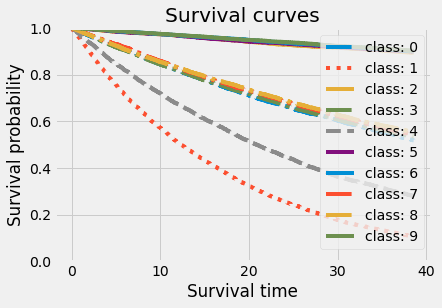

In [26]:
plt.style.use('fivethirtyeight')
style = ('-','-.','--',':')
for row in assignment.itertuples():
  mask = y_train == row.Index
  x_cor, y_cor = kaplan_meier_estimator(event_train[mask], time_train[mask])
  ls = style[row.risk_groups]
  plt.step(x_cor, y_cor, where = 'post',label = f"class: {row.Index}", linestyle = ls)
  plt.ylim(0,1)
  plt.xlabel('Survival time')
  plt.ylabel('Survival probability')
  plt.title('Survival curves')
  plt.legend()
  




In [27]:
#We can training the neural network to optimize the cph partial log likelihood function:
#We prepare the data, get the shapes, change into tensors, divide into batches and computing
#The loss function. The hard work will be computation of the loss function (The denominator of the partial log-likelihood)
#which represent the risk set involves some tedious codding:

In [28]:
#We now create the risk set as follows:

In [29]:
def _risk_set_creation(time: np.ndarray)->np.ndarray:
  assert time.ndim == 1 #must be of dim-1
  o = np.argsort(-time, kind = 'mergesort')
  sample_size = len(time)
  risk_set = np.zeros(shape = (sample_size, sample_size), dtype = np.bool)
  for i, j in enumerate(o):
    ti = time[j]
    k = i
    while k < sample_size and ti == time[o[k]]:
      k+=1
      risk_set[j, o[:k]] = True
  return risk_set



In [30]:
#Since we cannot load all the data into the memory 
#We create a class to streams data in batches for easy training: 
class InputFunction:
  def __init__(self,
               image:np.ndarray,
               event: np.ndarray,
               time: np.ndarray,
               shuffle: np.bool = False,
               drop_last: np.bool = False,
               seed: int = 23,
               batch_size: int = 64,
               )-> None:
    if image.ndim == 3:
      image = image[..., np.newaxis]
    self.image = image
    self.time = time
    self.event = event
    self.shuffle = shuffle
    self.drop_last = drop_last
    self.seed = seed
    self.batch_size = batch_size
  
  def size(self)-> int:
    return self.image.shape[0]
  
  def steps_per_epoch(self)-> int:
    return int(np.floor(self.size()/self.batch_size))
  def _get_data_batch(self, index: np.ndarray)-> Tuple[np.ndarray, Dict[str, np.ndarray]]:
    time = self.time[index]
    event = self.event[index]
    image = self.image[index]
    labels = {'label_event': event.astype(np.int32),
              'label_time': time.astype(np.float32),
              'label_riskset': _risk_set_creation(time)}
    return image, labels
  def _iter_data(self)-> Iterable[Tuple[np.ndarray, Dict[str, np.ndarray]]]:
    index = np.arrange(self.size())
    rnd = np.random.RandomState(self.seed)
    if self.shuffle:
      rnd.shuffle(index)
    for b in range(steps_per_epoch()):
      start = b * self.batch_size
      idx = index[start:(start + self.batch_size)]
      yield self._get_data_batch(idx)
    if not self.drop_last:
      start = self.steps_per_epoch() * self.batch_size
      idx = index[start:]
      yield self._get_data_batch(idx)
  def _get_shape(self)-> Tuple[tf.TensorShape, Dict[str, tf.TensorShape]]:
    batch_size = self.batch_size if self.drop_last else None
    h, w, c = self.image[1:]
    image = tf.TensorShape([batch_size, h, w, c])
    labels = {k: tf.TensorShape((batch_size,))
    for k in ('label_event', 'label_time')}
    return image, labels
  def get_dtype(self)->Tuple[tf.DType, Dict[str, tf.DType]]:
    labels = {
        'label_event':tf.int32,
        'label_time': tf.float32,
        'label_riskset': tf.bool}
    return tf.float32, labels
  def create_dataset(self)->tf.data.Dataset:
    dfm = tf.data.Dataset.from_generator(
        self._iter_data,
        self._get_shape(),
        self.get_dtype())
    return dfm
  def __call__(self)->tf.data.Dataset:
    return self.create_dataset()


In [31]:
#We now normalize the risk-scores to varies in a positive range of values and avoiding extremes 
#when computing the exponent.


In [32]:
def nomalize_risk_scores(x: tf.Tensor)->tf.Tensor:
  x_min_value = tf.reduce_min(x, axis = 0)
  ctr = tf.zero_like(x_min_value)
  x_norm = tf.where(x_min_value < ctr, -x_min_value, ctr)
  return x + x_norm

In [33]:
#We now compute the log_summation of the denominator of the CPH partial-likelihood function:
def comp_logsum(risk_scores: tf.Tensor,
                mask: tf.Tensor,
                axis: int = 0,
                keepdims:Optional[bool] = None)-> tf.Tensor:
  risk_scores.shape.assert_same_rank(mask.shape)
  with tf.name_scope('comp_logsum'):
    mask_c = tf.cast(mask, risk_scores.dtype)
    masked_risk_scores = tf.math.multiply(risk_scores, mask_c)
    max_score = tf.reduce_max(masked_risk_scores, axis = axis, keepdims= True) 
    masked_risk_scores_adj = masked_risk_scores - max_score #We adjust the risk-scores to avoid extremes in exponents
    exp_masked = tf.math.multiply(tf.exp(masked_risk_scores_adj), mask_c)
    exp_sum = tf.reduce_sum(exp_masked, axis = axis, keepdims = True)
    output = max_score + tf.math.log(exp_sum)
    if not keepdims:
      output = tf.squeeze(output, axis = axis)
  return output



In [34]:
#Now we compute the loss function (CPH-Loss) using the above tools:

In [37]:
class My_CPH_Loss(tf.keras.losses.Loss):
  def __init__(self, name = 'cph_loss', **kwargs):
    super(My_Loss, self).__init__(name = name, **kwargs)
  
  def call(self, y_real: Sequence[tf.Tensor],
                y_pred: tf.Tensor)->tf.Tensor:
    event, riskset = y_real
    predictions = y_pred

    pred_shape = predictions.shape
    if pred_shape.ndims != 2:
      raise ValueError(f"rank mismatch: rank of prediction received is {pre_shape.ndims}: must be 2")
    if pred_shape[1] is None:
      raise ValueError(f"the last dimension of the prediction must be known")
    if pred_shape[1] != 1:
      raise ValueError(f"The last dimension of the prediction must be 1:{pred_shape[1]} were given")
    if event.shape.ndims != pred_shape.ndims:
      raise ValueError(f"dimension mismatch: rank {pred_shape.ndims}of the prediction given is not equal to the rank {event.shape.ndims} of event given")
    if riskset.shape.ndims != 2:
      raise ValueError(f"rank mismatch: the rank of the risk set must be 2: {riskset.shape.ndims} were given")
    
    event = tf.cast(event, predictions.dtype)
    predictions = nomalize_risk_scores(predictions)

    with tf.name_scope('assertions'):
      assertions = (
          tf.debugging.assert_less_equal(event, 1.),
          tf.debugging.assert_greater_equal(event,0.),
          tf.debugging.assert_type(riskset, tf.bool)
      )
    predictions_trn = tf.transpose(predictions) #Move the batch dimension to the end to allow broadcasting in preds when get multiplied by a riskset
    my_risk = comp_logsum(predictions_trn, riskset, axis = 1, keepdims = True)
    assert my_risk.shape.as_list() == predictions.shape.as_list() #risk scores must be same dimension as predictions:
    losses = tf.math.multiply(event, (my_risk - predictions)) #Loss per instance
    return losses

  